<a href="https://colab.research.google.com/github/dhcryan/dm_project/blob/main/new1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import *
from scipy.spatial.distance import cdist
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics.pairwise as sim
from collections import OrderedDict
from PIL import Image
import requests
from bs4 import BeautifulSoup
import json
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
!pip install ipywidgets
from ipywidgets import interact
import ipywidgets as widgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.7 MB/s 


In [3]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 199 kB 28.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=a087967d787e650ac01923a6a8095964b991391bad819e7834bc457f4ce3fe1d
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import re
import sys
import itertools as it
from pyspark import SparkConf, SparkContext

In [7]:
import pyspark
from pyspark.sql import SQLContext

In [8]:
file_path='/content/drive/MyDrive'
fifa_path='/players_fifa23.csv'

import pyspark 
from pyspark.sql import SparkSession 


In [9]:
spark=SparkSession.builder.appName('fifa').getOrCreate()

In [10]:
# # File location and type
# file_location = "/content/drive/MyDrive/players_fifa23.csv"
# file_type = "csv"

# # CSV options
# infer_schema = "true"
# first_row_is_header = "true"
# delimiter = ","

# # The applied options are for CSV files. For other file types, these will be ignored.
# df = spark.read.format(file_type) \
#   .option("inferSchema", infer_schema) \
#   .option("header", first_row_is_header) \
#   .option("sep", delimiter) \
#   .load(file_location)

# df.show(10)

In [11]:
# # The applied options are for CSV files. For other file types, these will be ignored.
df=spark.read.option("inferSchema", "true").option("header", "true").csv('/content/drive/MyDrive/players_fifa23.csv')
df.show(10) 

+--------+-----------------------+------------------------------------+----+-------+-------+-------------------------------------------------+-------------------------+--------+----------+-------+-----------+----------+--------------+-------------+--------------------------------------+----------+--------+--------------+-------------+--------------+-----------+-----------+-------+--------------------+-----------------+---------------+--------------+--------------+---------+-----------+------------------+------------------+----------+--------------+-------------+---------------+---------------+-----------------+---------+----------+----------------+-------------+--------+----------+------+-----------+------------+------------+-------------+------------+--------+----------+--------+----------+--------+--------+---------+----------+-----------+--------------+------------+-------+----------+----------+--------+---------------+--------------+---------+-----------+----------+--------------+-

In [12]:
from pyspark.sql.functions import trim
#strip header space
for each in df.schema.names:
    df = df.withColumnRenamed(each,re.sub(r'\s+([a-zA-Z_][a-zA-Z_0-9]*)\s*','',each.replace(' ', '')))
df.show(10)

+--------+--------------------+--------------------+----+------+------+--------------------+--------------------+-------+---------+------+----------+---------+--------------+-------------+--------------------+--------+--------+-------------+-------------+--------------+-----------+----------+-------+--------------------+-----------------+---------------+--------------+-------------+--------+----------+------------------+------------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---

In [13]:
from pyspark.sql.functions import *

for c_name in df.columns:
    if c_name in ['Name','FullName','PhotoUrl','Nationality','Positions','BestPosition','ClubPosition','ContractUntil','ClubNumber','OnLoad','NationalTeam','NationalPosition','NationalNumber','PreferredFoot','AttackingWorkRate','DefensiveWorkRate']:
      df = df.withColumn(c_name, trim(col(c_name)))
df.show()

+--------+-----------------+--------------------+----+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+-------

### missing value analysis


In [14]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
missing_df = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
missing_df.show()

# ClubPosition|ContractUntil|ClubNumber 92개의 missing value
# NationalPosition|NationalNumber -> 국대 아닌 선수들 17722
# 그 외의 결측치 없음

+---+----+--------+---+------+------+--------+-----------+-------+---------+------+----------+---------+---------+------------+----+--------+-------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+--------+--------+
| ID|Name|FullName|Age|Height|Weight|PhotoUrl|Natio

In [15]:
df.printSchema()

root
 |-- ID: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- PhotoUrl: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: double (nullable = true)
 |-- Potential: double (nullable = true)
 |-- Growth: double (nullable = true)
 |-- TotalStats: double (nullable = true)
 |-- BaseStats: double (nullable = true)
 |-- Positions: string (nullable = true)
 |-- BestPosition: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ValueEUR: double (nullable = true)
 |-- WageEUR: double (nullable = true)
 |-- ReleaseClause: double (nullable = true)
 |-- ClubPosition: string (nullable = true)
 |-- ContractUntil: string (nullable = true)
 |-- ClubNumber: string (nullable = true)
 |-- ClubJoined: double (nullable = true)
 |-- OnLoad: string (nullable = true)
 |-- NationalTeam: string (nullabl

In [16]:
from pyspark.sql.types import IntegerType
df=df.withColumn("ID",df["ID"].cast(IntegerType()))
df=df.withColumn("Age",df["Age"].cast(IntegerType()))
df=df.withColumn("Overall",df["Overall"].cast(IntegerType()))
df=df.withColumn("Potential",df["Potential"].cast(IntegerType()))
df=df.withColumn("IntReputation",df["IntReputation"].cast(IntegerType()))
df=df.withColumn("SkillMoves",df["SkillMoves"].cast(IntegerType()))
df=df.withColumn("WeakFoot",df["WeakFoot"].cast(IntegerType()))
df=df.withColumn("Height",df["Height"].cast(IntegerType()))
df=df.withColumn("Weight",df["Weight"].cast(IntegerType()))


In [17]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- PhotoUrl: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Growth: double (nullable = true)
 |-- TotalStats: double (nullable = true)
 |-- BaseStats: double (nullable = true)
 |-- Positions: string (nullable = true)
 |-- BestPosition: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ValueEUR: double (nullable = true)
 |-- WageEUR: double (nullable = true)
 |-- ReleaseClause: double (nullable = true)
 |-- ClubPosition: string (nullable = true)
 |-- ContractUntil: string (nullable = true)
 |-- ClubNumber: string (nullable = true)
 |-- ClubJoined: double (nullable = true)
 |-- OnLoad: string (nullable = true)
 |-- NationalTeam: string (n

### attribute 분류

In [18]:
print(df.show())

+------+-----------------+--------------------+---+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+--------+-

In [19]:
Fifa_df = df.toPandas()
print(Fifa_df)

           ID            Name            FullName  Age  Height  Weight  \
0      158023        L. Messi        Lionel Messi   35     169      67   
1      165153      K. Benzema       Karim Benzema   34     185      81   
2      188545  R. Lewandowski  Robert Lewandowski   33     185      81   
3      192985    K. De Bruyne     Kevin De Bruyne   31     181      70   
4      231747       K. Mbappé       Kylian Mbappé   23     182      73   
...       ...             ...                 ...  ...     ...     ...   
18534  243725      D. Collins      Darren Collins   21     174      68   
18535  261933    Yang Dejiang        Dejiang Yang   17     175      60   
18536  267823       L. Mullan         Liam Mullan   18     170      65   
18537  267824    D. McCallion    Daithí McCallion   17     178      65   
18538  261424        N. Rabha         Nabin Rabha   25     176      66   

                                               PhotoUrl          Nationality  \
0      https://cdn.sofifa.net/p

In [20]:
Fifa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 18539 non-null  int32  
 1   Name               18539 non-null  object 
 2   FullName           18539 non-null  object 
 3   Age                18539 non-null  int32  
 4   Height             18539 non-null  int32  
 5   Weight             18539 non-null  int32  
 6   PhotoUrl           18539 non-null  object 
 7   Nationality        18539 non-null  object 
 8   Overall            18539 non-null  int32  
 9   Potential          18539 non-null  int32  
 10  Growth             18539 non-null  float64
 11  TotalStats         18539 non-null  float64
 12  BaseStats          18539 non-null  float64
 13  Positions          18539 non-null  object 
 14  BestPosition       18539 non-null  object 
 15  Club               18539 non-null  object 
 16  ValueEUR           185

## Clustering


In [21]:
#gk와 non gk구분 
def segment_gk(Fifa_df):
  gk_data=Fifa_df[Fifa_df.BestPosition=='GK']
  nongk_data=Fifa_df[Fifa_df.BestPosition!='GK']
  return gk_data,nongk_data
  

In [22]:
gk,non_gk=segment_gk(Fifa_df)


In [23]:
# attrs=['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve'\
#        ,'FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions'\
#        ,'Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions'\
#        ,'Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle'\
#        ,'GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']
def cluster_attrs(nongk):    
    attrs_groups = dict()
    attrs_groups['passing'] = ['Crossing','ShortPassing','FKAccuracy','LongPassing','Vision']
    attrs_groups['shooting'] = ['Finishing','LongShots','Penalties','ShotPower','Volleys','Curve']
    attrs_groups['pace'] = ['Acceleration','SprintSpeed']
    attrs_groups['skill'] = ['BallControl','Dribbling']
    attrs_groups['movement']=['Agility','Reactions','Positioning','Composure']
    attrs_groups['defending'] = ['Interceptions','Marking','StandingTackle','SlidingTackle']
    attrs_groups['pysicality'] = ['Aggression','Stamina','Strength','Balance','Jumping','HeadingAccuracy']
    #attrs_groups['goalkeeping'] = ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']
    pass_index=nongk[attrs_groups['passing']].mean(axis=1)
    shoot_index=nongk[attrs_groups['shooting']].mean(axis=1)
    pace_index=nongk[attrs_groups['pace']].mean(axis=1)
    skill_index=nongk[attrs_groups['skill']].mean(axis=1)
    movement_index=nongk[attrs_groups['movement']].mean(axis=1)
    defense_index=nongk[attrs_groups['defending']].mean(axis=1)
    pysical_index=nongk[attrs_groups['pysicality']].mean(axis=1)
    
    index_concat=pd.concat([pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index],axis=1,ignore_index=True)
    #radar chart만들기 위해 normalize해야 할 필요성 있음 min-max normalization
    nongk_value = index_concat.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
    nongk_scaled=scaler.fit_transform(nongk_value)
    return nongk_scaled.round(2)

In [24]:
nongk_scaled=cluster_attrs(non_gk)
nongk_df= pd.DataFrame(nongk_scaled)
nongk_df.columns=['pass_index','shoot_index','pace_index','skill_index','movement_index','defense_index','pysical_index']

코드 실행 후 아래와 같이 표준화된 결과를 얻을 수 있다. 

In [25]:
nongk_df.head()

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76


## PCA & CLUSTERING

### PCA

After fitting a PCA object to the standardized matrix, we can see how much of the variance is explained by each of the nine features.

In [26]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(nongk_scaled)
evr = pca.explained_variance_ratio_
print(evr)

[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


In general, it is a good rule of thumb to preserve around 80% of the variance. Therefore, in this instance, we can select the 3 most important principal components to incorporate in the k-means algorithm.

PCA를 단계적으로 진행할 경우, 공분산 행렬을 통해 고윳값(eigenvalue)과 고유벡터(eigenvector)를 구할 수 있다. 
이때, 고윳값이 설명 가능한 분산량에 해당한다. 
위의 그래프는 주성분 각각의 고윳값을 고윳값들을 모두 더한 값으로 나눠 준 것이다.
즉, 전체에서 해당 주성분의 고윳값이 차지하는 비율을 알아보는 것이다

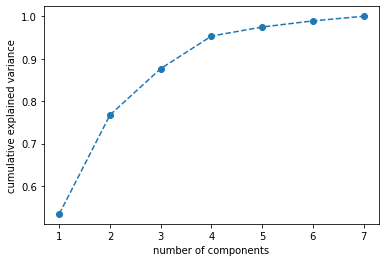

In [27]:
plt.plot(range(1,len(nongk_df.columns)+1),np.cumsum(evr),marker='o',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

원래 dimension이 7이었는데
위 소스 코드의 핵심은 PCA의 파라미터 주성분 개수(n_components)를 결정하여 개수에 맞는 원래 데이터에서 변환된 주성분을 추출하는 것이다. 본 글에서는 주성분을 4개로 결정하였다. (분산이 제일 큰 놈 4개: 데이터가 널리 퍼진거)

This can be accomplished by instantiating a new PCA object with the n_components parameter set to 3.

The explained variance, or eigenvalue, in PCA shows the variance that can be attributed to each of the principal components.

In [28]:
for i, exp_var in enumerate(evr.cumsum()):
  print(i+1,"번째 분산량",evr[i], '\t','누적 분산량: ',exp_var)
  if exp_var >= 0.95:
      n_comps = i + 1
      break
print("Number of components:", n_comps)
# print(sum(evr,[]))
print(pca.explained_variance_ratio_)
pca = PCA(n_components=n_comps)
pca.fit(nongk_scaled)
nongk_scaled_pca = pca.transform(nongk_scaled)

1 번째 분산량 0.5340622533591339 	 누적 분산량:  0.5340622533591339
2 번째 분산량 0.23331979918533788 	 누적 분산량:  0.7673820525444718
3 번째 분산량 0.10916885512772596 	 누적 분산량:  0.8765509076721978
4 번째 분산량 0.07671527456626721 	 누적 분산량:  0.953266182238465
Number of components: 4
[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


### Elbow Method for optimal value of k in KMeans

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the kneed KneeLocator

In [29]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데
# 이 지점의 K 값을 군집의 개수로 사용
# inertia_속성으로 확인할 수 있다.
# 클러스터 간 거리의 합을 나타내는 inertia value가 급격히 떨어지는 구간 이용
from kneed import KneeLocator
inertia_arr=[]
def elbow_point_for_k(nongk_scaled_pca):
  global inertia_arr
  k_range=range(2,15)
  for k in k_range:
    kmeans_pca=KMeans(n_clusters=k).fit(nongk_scaled_pca)
    inertia=kmeans_pca.inertia_
    inertia_arr.append(inertia)
    print('k value: ',k,'\t','cost: ',inertia)
  n_clusters = KneeLocator([i for i in k_range], inertia_arr, curve='convex', direction='decreasing').knee
  print("Optimal number of clusters", n_clusters)

In [31]:
elbow_point_for_k(nongk_scaled_pca)


k value:  2 	 cost:  70202.52290441419
k value:  3 	 cost:  55468.8669607006
k value:  4 	 cost:  46322.01114894837
k value:  5 	 cost:  41051.07858611901
k value:  6 	 cost:  37752.91912922532
k value:  7 	 cost:  34920.59013551743
k value:  8 	 cost:  32448.363179619413
k value:  9 	 cost:  30245.305270070105
k value:  10 	 cost:  28484.853602887226
k value:  11 	 cost:  27021.013337930628
k value:  12 	 cost:  25787.17650740361
k value:  13 	 cost:  24703.507623093457
k value:  14 	 cost:  23687.037768433176
Optimal number of clusters 5


In [32]:
inertia_arr
print(type(inertia_arr))

<class 'list'>


Text(0, 0.5, 'Average within-cluster sum-of-squares(inertia)')

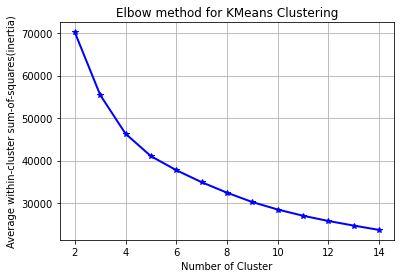

In [33]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(range(2,15),inertia_arr,'b*-',linewidth=2)
plt.grid(True)
# plt.vlines(KneeLocator([i for i in range(2,15)], inertia_arr, curve='convex', direction='decreasing').knee, ymin=min(inertia_arr), ymax=max(inertia_arr), linestyles='dashed')
plt.title('Elbow method for KMeans Clustering')
plt.xlabel('Number of Cluster')
plt.ylabel('Average within-cluster sum-of-squares(inertia)')

Finding the elbow point of the WCSS (within cluster sum of squares) curve using the YellowBrick KElbowVisualizer

In [34]:
from yellowbrick.cluster import KElbowVisualizer

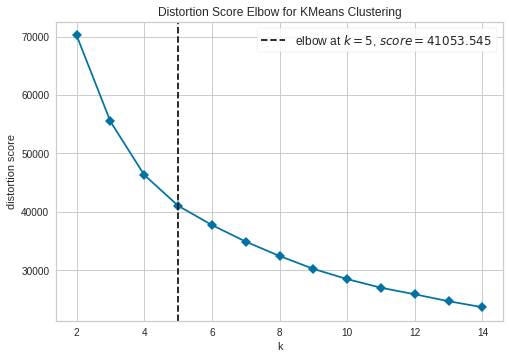

Optimal number of clusters: 5


In [35]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(2,15), timings=False)
visualizer.fit(nongk_scaled_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [36]:
number_of_clusters = 5
kmeanModel = KMeans(n_clusters = number_of_clusters ) 
kmeanModel.fit(nongk_scaled_pca)

KMeans(n_clusters=5)

In [37]:
# nongk_rescaled['Name']=non_gk['Name']
# nongk_rescaled['Overall']=non_gk['Overall']
# nongk_rescaled['BestPosition']=non_gk['BestPosition']
# nongk_rescaled.insert(0,'Name',non_gk['Name'])
# nongk_rescaled.insert(1,'Club',non_gk['Club'])
# nongk_rescaled['Cluster']=kmeanModel.labels_

In [38]:
type(nongk_scaled_pca)

numpy.ndarray

In [39]:
labels=kmeanModel.labels_

In [40]:
nongk_pca_kmeans_df = pd.concat([nongk_df.reset_index(drop=True), pd.DataFrame(nongk_scaled_pca)], axis=1)
nongk_pca_kmeans_df.columns.values[(-1*n_comps):] = ["PCA Component " + str(i+1) for i in range(n_comps)]
nongk_pca_kmeans_df['FullName']=non_gk['FullName'].reset_index(drop=True)
nongk_pca_kmeans_df['Cluster'] = labels
nongk_pca_kmeans_df['BestPosition']=non_gk['BestPosition'].reset_index(drop=True)
nongk_pca_kmeans_df

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77,6.726875,0.342237,0.615166,0.181881,Lionel Messi,3,CAM
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02,5.816280,-0.336014,0.132669,1.394052,Karim Benzema,3,CF
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82,5.701664,-1.078143,0.189942,1.999844,Robert Lewandowski,3,ST
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20,5.878852,-1.407581,0.854530,-0.417365,Kevin De Bruyne,3,CM
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76,6.356858,0.249218,-1.293110,0.964180,Kylian Mbappé,0,ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16473,-1.16,-0.33,0.01,-1.33,-1.28,-1.25,-3.39,-2.358325,3.163213,0.651042,-1.205391,Darren Collins,1,CAM
16474,-1.57,-1.29,-1.27,-1.83,-1.57,-0.16,-1.93,-3.583433,1.092952,0.832385,-0.595490,Dejiang Yang,4,CDM
16475,-0.73,-0.77,-0.36,-1.13,-1.40,-0.81,-2.52,-2.331546,2.086866,0.671840,-1.082719,Liam Mullan,1,RM
16476,-3.06,-1.98,-1.50,-3.57,-2.75,0.10,-1.83,-6.079749,1.002441,0.339134,-0.071356,Daithí McCallion,4,CB


In [41]:
# nongk_pca_kclustered = nongk_scaled_pca
# # nongk_clustered['Cluster']=labels
# nongk_pca_kclustered['Name']=non_gk['Name'].reset_index(drop=True)
# nongk_pca_kclustered['BestPosition']=non_gk['BestPosition'].reset_index(drop=True)
# nongk_pca_kclustered.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
# nongk_pca_kclustered['Cluster'] = labels
# nongk_pca_kclustered.head()
# # nongk_clustered.insert(1,'BestPosition',non_gk['BestPosition']).reset_index(drop=True)
# # nongk_clustered.insert(2,'Cluster',labels).reset_index(drop=True)


In [42]:
# nongk_clustered['Cluster']=labels
# nongk_clustered[nongk_clustered['BestPosition'].isnull()]

In [43]:
nongk_pca_kmeans_df[nongk_pca_kmeans_df['Cluster']==4]

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
317,-0.83,-1.88,-0.54,-0.03,-1.11,1.77,1.55,-1.858921,-2.398845,-0.879955,-0.017618,Robin Le Normand,4,CB
444,-1.06,-2.03,0.10,-0.73,-1.28,1.59,1.50,-2.283705,-2.035180,-1.544230,0.070163,Unai Núñez Gestoso,4,CB
628,-0.19,-1.18,-3.28,-0.63,-0.45,1.54,0.59,-2.055438,-2.491215,2.097914,0.000549,Guillermo Maripán,4,CB
738,-1.30,-1.91,0.51,-1.48,-0.71,1.41,2.61,-2.140516,-2.442256,-2.279435,1.117277,Joseph Aidoo,4,CB
792,-0.36,-1.29,-1.45,-0.63,-0.91,1.55,0.63,-1.922670,-1.960656,0.432855,-0.291907,Domingos Sousa Menezes Duarte,4,CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16470,-1.14,-1.26,-1.22,-1.48,-1.19,-0.17,-1.36,-2.918646,0.676999,0.754083,-0.386302,Wei Liao,4,CDM
16472,-1.06,-1.25,-0.45,-1.58,-1.48,-0.65,-1.41,-2.838487,1.265349,0.176290,-0.331666,Ziyang Pi,4,CAM
16474,-1.57,-1.29,-1.27,-1.83,-1.57,-0.16,-1.93,-3.583433,1.092952,0.832385,-0.595490,Dejiang Yang,4,CDM
16476,-3.06,-1.98,-1.50,-3.57,-2.75,0.10,-1.83,-6.079749,1.002441,0.339134,-0.071356,Daithí McCallion,4,CB


In [44]:
# kmeans clustering의 문제점: 선수 능력치가 낮은 애들은 그냥 선수특성이고 나발이고 낮은 능력치 애들로 clustering됨

def show_cluster_samples(df, cluster_no, number_of_samples):
    return  df[df['Cluster'] == cluster_no][:number_of_samples]
for cluster_no in range(number_of_clusters):
    display(show_cluster_samples(nongk_pca_kmeans_df, cluster_no, 20))

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76,6.356858,0.249218,-1.293110,0.964180,Kylian Mbappé,0,ST
6,2.22,2.93,1.15,2.40,3.35,-1.36,2.02,5.887637,-0.088558,0.040198,1.684961,C. Ronaldo dos Santos Aveiro,0,ST
9,2.92,2.60,1.70,3.20,3.32,-1.02,0.44,6.323095,0.627980,0.082362,-0.131042,Neymar da Silva Santos Jr.,0,LW
10,2.39,2.56,1.75,2.30,3.21,-0.74,0.84,5.619751,0.290989,-0.298451,0.295789,Heung Min Son,0,LW
16,0.65,2.71,1.80,1.76,2.69,-0.51,2.39,4.594135,-0.443562,-1.184781,1.946045,Erling Haaland,0,ST
33,0.85,2.50,1.52,1.76,2.40,-0.94,2.11,4.361989,-0.102262,-0.819436,1.886209,Ciro Immobile,0,ST
34,1.67,2.43,0.97,1.76,1.97,-1.09,1.50,4.269005,0.081458,0.034521,1.301281,Romelu Lukaku,0,ST
36,2.04,1.91,1.98,2.25,3.12,-0.40,0.40,5.063512,0.362448,-0.692652,-0.260671,Raheem Sterling,0,LW
37,2.41,2.39,1.11,2.80,2.78,-0.97,-0.05,5.301067,0.809534,0.534249,-0.231145,Riyad Mahrez,0,RW
43,2.14,2.01,2.16,2.50,2.75,-1.49,0.14,5.183788,1.353528,-0.570915,0.033943,Kingsley Coman,0,LM


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
3406,0.09,1.69,-3.24,0.66,0.19,-1.12,-1.53,0.242570,1.007407,3.936845,0.420762,Roque Santa Cruz,1,ST
3579,-0.97,0.94,-1.54,0.31,0.50,-1.42,0.49,0.156907,0.540790,1.421077,1.930479,Luca Pfeiffer,1,ST
3657,-1.08,0.72,-0.08,0.26,-0.19,-2.13,0.70,0.107245,1.351983,0.099337,2.142336,Daryl Dike,1,ST
3992,-1.22,1.21,-1.00,-0.28,1.39,-1.61,-0.35,0.355259,1.374019,1.155297,1.663378,Simeon Tochukwu Nwankwo,1,ST
4021,-0.40,1.11,-1.45,-0.28,0.24,-1.46,0.47,0.103027,0.536712,1.507844,1.829305,Milan Đurić,1,ST
4022,1.16,0.75,-0.08,1.31,-0.30,-1.25,-1.93,1.158376,1.951060,1.342770,-1.092103,Sávio Moreira de Oliveira,1,CAM
4088,-1.79,0.71,-1.36,0.51,0.22,-1.58,1.06,-0.223144,0.488325,0.884269,2.566642,Andrea La Mantia,1,ST
4109,-0.67,1.11,-0.08,-0.38,0.56,-1.85,0.19,0.439291,1.404555,0.353563,1.736602,Ignacio Ramírez,1,ST
4138,-0.69,1.40,-1.64,0.61,-0.10,-1.19,-0.14,0.212966,0.781375,1.900249,1.328875,Alberto Cerri,1,ST
4230,-1.16,0.95,-0.08,0.61,0.47,-1.52,-0.10,0.514407,1.427474,0.301912,1.349399,Matías Cóccaro,1,ST


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
29,-0.24,-1.31,1.15,0.86,0.19,2.06,1.53,0.173179,-2.192184,-2.055017,-0.601848,Kalidou Koulibaly,2,CB
47,-0.30,-0.78,0.88,0.71,0.36,2.05,2.28,0.438924,-2.643929,-1.898528,0.153084,Milan Škriniar,2,CB
51,0.62,-0.40,0.15,-0.18,-0.13,1.92,1.20,0.018890,-2.197707,-0.660209,-0.526339,Niklas Süle,2,CB
87,-0.20,-1.39,-0.40,-0.53,0.13,2.01,1.83,-0.915996,-2.808926,-0.886914,0.068638,Stefan Savić,2,CB
102,-0.03,0.05,-0.26,-0.63,-0.07,1.96,1.95,-0.262966,-2.626102,-0.567875,0.458913,Giorgio Chiellini,2,CB
125,0.11,-1.06,1.52,0.11,0.91,1.95,2.23,0.645135,-2.505649,-2.476043,-0.037771,Fikayo Tomori,2,CB
147,-0.34,-0.40,0.47,0.11,0.79,1.91,2.35,0.428040,-2.671275,-1.496038,0.573154,Cristian Romero,2,CB
152,0.54,-0.41,0.70,-0.18,0.70,1.79,2.09,0.671140,-2.520466,-1.421214,0.132855,Ronald Araujo,2,CB
156,-0.05,-0.61,0.19,-0.23,-0.42,1.94,2.11,-0.411475,-2.649227,-1.164368,0.258992,José María Giménez,2,CB
158,-0.46,-0.47,0.83,0.11,0.93,1.85,2.02,0.462111,-2.320390,-1.765839,0.350536,Gleison Bremer Silva Nascimento,2,CB


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77,6.726875,0.342237,0.615166,0.181881,Lionel Messi,3,CAM
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02,5.816280,-0.336014,0.132669,1.394052,Karim Benzema,3,CF
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82,5.701664,-1.078143,0.189942,1.999844,Robert Lewandowski,3,ST
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20,5.878852,-1.407581,0.854530,-0.417365,Kevin De Bruyne,3,CM
5,2.31,2.70,1.98,2.65,3.52,-0.40,1.45,6.095835,-0.232463,-0.670677,0.525524,Mohamed Salah,3,RW
7,1.49,0.70,1.02,1.06,1.22,2.21,2.30,2.563735,-2.884141,-1.184262,-0.216847,Virgil van Dijk,3,CB
8,2.43,2.92,-0.03,2.10,2.92,-0.52,2.32,5.290194,-1.217865,0.931740,1.592610,Harry Kane,3,ST
11,1.90,1.48,-0.49,1.01,1.80,2.06,2.79,3.056038,-3.503582,0.319955,0.553757,Carlos Henrique Venancio Casimiro,3,CDM
12,2.04,2.15,2.02,2.45,3.26,-0.68,2.56,5.683272,-0.717845,-1.213182,1.398117,Sadio Mané,3,LM
13,2.84,1.53,0.01,2.10,2.66,1.81,2.44,4.564991,-3.169792,0.291899,-0.079556,Joshua Kimmich,3,CDM


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
317,-0.83,-1.88,-0.54,-0.03,-1.11,1.77,1.55,-1.858921,-2.398845,-0.879955,-0.017618,Robin Le Normand,4,CB
444,-1.06,-2.03,0.10,-0.73,-1.28,1.59,1.50,-2.283705,-2.035180,-1.544230,0.070163,Unai Núñez Gestoso,4,CB
628,-0.19,-1.18,-3.28,-0.63,-0.45,1.54,0.59,-2.055438,-2.491215,2.097914,0.000549,Guillermo Maripán,4,CB
738,-1.30,-1.91,0.51,-1.48,-0.71,1.41,2.61,-2.140516,-2.442256,-2.279435,1.117277,Joseph Aidoo,4,CB
792,-0.36,-1.29,-1.45,-0.63,-0.91,1.55,0.63,-1.922670,-1.960656,0.432855,-0.291907,Domingos Sousa Menezes Duarte,4,CB
834,-1.10,-0.51,-1.68,-0.28,-0.71,1.54,0.70,-1.680437,-1.826788,0.687902,0.229379,Germán Pezzella,4,CB
900,0.05,-1.35,-1.00,-1.08,-1.05,1.54,0.63,-1.932366,-1.903462,0.095786,-0.471723,Dan-Axel Zagadou,4,CB
918,-0.85,-1.51,-1.68,-0.43,-1.28,1.47,0.87,-2.353688,-2.038958,0.420143,0.024801,Axel Disasi,4,CB
933,-1.24,-1.21,-0.22,-1.53,-0.42,1.55,1.81,-1.989117,-2.189402,-1.228440,0.804870,Vitor Hugo Franchescoli Souza,4,CB
1011,-0.13,-1.31,-2.19,-0.28,-1.08,1.52,0.70,-1.923523,-2.227045,1.140046,-0.249944,Germán Sánchez Barahona,4,CB


What is 3D PCA?
Most of the time, a PCA plot is a 2D scatter plot in which the data is plotted with two most descriptive principal components. However, you can choose to plot with three PCs instead, and this will create a 3D scatter plot, also called 3D PCA. 

The key difference between 2D PCA and 3D PCA is the number of principal components being selected for plotting. In PCA, principal components are constructed to capture the most variation in the dataset: PC1 describes the most variation, PC2 describes the second most variation, and so forth. As a result, the first two or three PCs can capture most of the variation and the rest can be discarded without losing much information. This can be seen in a scree plot.

In [45]:
type(nongk_pca_kmeans_df['Cluster'])

pandas.core.series.Series

In [46]:
labels_df=pd.DataFrame(labels,columns=['Cluster'])
non_gk = pd.concat([non_gk.reset_index(drop=True), labels_df], axis=1)
non_gk

,ID,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,...,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating,Cluster
0,158023,L. Messi,Lionel Messi,35,169,67,https://cdn.sofifa.net/players/158/023/23_60.png,Argentina,91,91,...,88.0,91.0,67.0,66.0,67.0,62.0,53.0,62.0,22.0,3
1,165153,K. Benzema,Karim Benzema,34,185,81,https://cdn.sofifa.net/players/165/153/23_60.png,France,91,91,...,84.0,89.0,67.0,67.0,67.0,63.0,58.0,63.0,21.0,3
2,188545,R. Lewandowski,Robert Lewandowski,33,185,81,https://cdn.sofifa.net/players/188/545/23_60.png,Poland,91,91,...,83.0,86.0,67.0,69.0,67.0,64.0,63.0,64.0,22.0,3
3,192985,K. De Bruyne,Kevin De Bruyne,31,181,70,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,91,91,...,91.0,91.0,82.0,82.0,82.0,78.0,72.0,78.0,24.0,3
4,231747,K. Mbappé,Kylian Mbappé,23,182,73,https://cdn.sofifa.net/players/231/747/23_60.png,France,91,95,...,84.0,92.0,70.0,66.0,70.0,66.0,57.0,66.0,21.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16473,243725,D. Collins,Darren Collins,21,174,68,https://cdn.sofifa.net/players/243/725/23_60.png,Republic of Ireland,47,56,...,44.0,50.0,41.0,38.0,41.0,40.0,36.0,40.0,15.0,1
16474,261933,Yang Dejiang,Dejiang Yang,17,175,60,https://cdn.sofifa.net/players/261/933/23_60.png,China PR,47,57,...,45.0,45.0,47.0,48.0,47.0,49.0,49.0,49.0,15.0,4
16475,267823,L. Mullan,Liam Mullan,18,170,65,https://cdn.sofifa.net/players/267/823/23_60.png,Northern Ireland,47,67,...,49.0,52.0,46.0,44.0,46.0,46.0,42.0,46.0,17.0,1
16476,267824,D. McCallion,Daithí McCallion,17,178,65,https://cdn.sofifa.net/players/267/824/23_60.png,Republic of Ireland,47,61,...,33.0,33.0,44.0,42.0,44.0,47.0,49.0,47.0,15.0,4


## visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


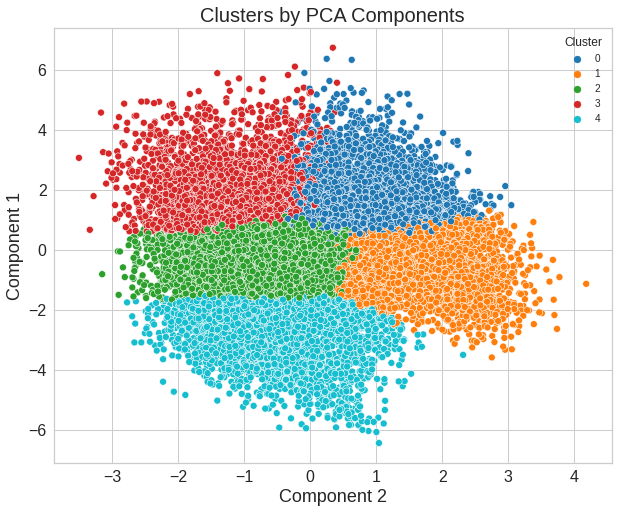

In [47]:
pca2 = nongk_pca_kmeans_df['PCA Component 2']
pca1 = nongk_pca_kmeans_df['PCA Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(pca2, pca1, hue=nongk_pca_kmeans_df['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:cyan'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [48]:
# Xax = nongk_pca_kmeans_df['PCA Component 1']
# Yax = nongk_pca_kmeans_df['PCA Component 2']
# Zax = nongk_pca_kmeans_df['PCA Component 3']
# y=labels


# cdict = {0:'red',1:'green',2:'royalblue',3:'violet',4:'gold'}
# labl = {0:'Cluster1',1:'Cluster2',2:'Cluster3',3:'Cluster4',4:'Cluster5'}
# marker = {0:'*',1:'o',2:'H',3:'d',4:'v'}
# alpha = {0:.3, 1:.5,2:.2,3:.4,4:.6}

# fig = plt.figure(figsize=(7,5))
# ax = fig.add_subplot(111, projection='3d')

# fig.patch.set_facecolor('white')
# for l in np.unique(y):
#  ix=np.where(y==l)
#  ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
#            label=labl[l], marker=marker[l], alpha=alpha[l])
# # for loop ends
# ax.set_xlabel("First Principal Component", fontsize=14)
# ax.set_ylabel("Second Principal Component", fontsize=14)
# ax.set_zlabel("Third Principal Component", fontsize=14)

# ax.legend()
# plt.show()

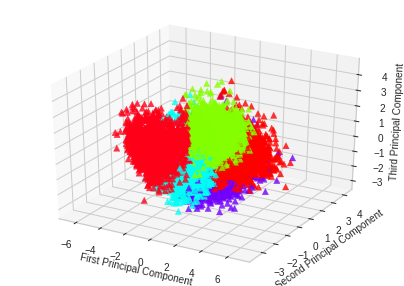

In [49]:
Xax = np.array(nongk_pca_kmeans_df['PCA Component 1'])
Yax = np.array(nongk_pca_kmeans_df['PCA Component 2'])
Zax = np.array(nongk_pca_kmeans_df['PCA Component 3'])
y=labels
# cdict = {0:'red',1:'green',2:'royalblue',3:'violet',4:'gold'}
# labl = {0:'Cluster1',1:'Cluster2',2:'Cluster3',3:'Cluster4',4:'Cluster5'}
# marker = {0:'*',1:'o',2:'H',3:'d',4:'v'}
# alpha = {0:.3, 1:.5,2:.2,3:.4,4:.6}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor('white')

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('hsv')
pca_clustered_sctt=ax.scatter(Xax,Yax,Zax,alpha=0.8, marker="^",c=nongk_pca_kmeans_df["Cluster"],s=40,cmap=my_cmap)
ax.set_xlabel("First Principal Component", fontsize=10)
ax.set_ylabel("Second Principal Component", fontsize=10)
ax.set_zlabel("Third Principal Component", fontsize=10)

# fig.colorbar(pca_clustered_sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.legend()
plt.show()

In [50]:
nongk_pca_kmeans_df.head()

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,FullName,Cluster,BestPosition
0,3.43,2.80,1.20,3.15,3.67,-1.22,0.77,6.726875,0.342237,0.615166,0.181881,Lionel Messi,3,CAM
1,2.45,2.67,1.02,2.65,3.09,-1.15,2.02,5.816280,-0.336014,0.132669,1.394052,Karim Benzema,3,CF
2,2.24,2.85,0.65,2.45,3.09,-0.85,2.82,5.701664,-1.078143,0.189942,1.999844,Robert Lewandowski,3,ST
3,3.52,2.80,0.56,2.65,2.86,0.67,1.20,5.878852,-1.407581,0.854530,-0.417365,Kevin De Bruyne,3,CM
4,2.14,2.58,2.62,2.95,3.49,-1.07,1.76,6.356858,0.249218,-1.293110,0.964180,Kylian Mbappé,0,ST


This is only a 2D visualization of a 4-dimensional pca vector space, so more analysis is needed in order to determine the efficacy of the k-means algorithm.Since meaning cannot be inferred from the transformed components, let’s take a look at the raw values for the audio features of the tracks after they have been clustered. A radar chart can be really powerful in this type of analysis because it allows us to make some quick observations about each cluster.

In [51]:
non_gk.loc[:,['Cluster']]

,Cluster
0,3
1,3
2,3
3,3
4,0
...,...
16473,1
16474,4
16475,1
16476,4


In [52]:
nongk_abil=non_gk.iloc[:,39:68]
non_gk_new = pd.concat([labels_df,nongk_abil.reset_index(drop=True)], axis=1)
non_gk_new

,Cluster,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,3,84.0,90.0,70.0,91.0,88.0,95.0,93.0,93.0,90.0,...,91.0,44.0,40.0,93.0,94.0,75.0,96.0,20.0,35.0,24.0
1,3,75.0,92.0,90.0,89.0,88.0,87.0,82.0,73.0,76.0,...,80.0,63.0,39.0,92.0,89.0,84.0,90.0,43.0,24.0,18.0
2,3,71.0,94.0,91.0,84.0,89.0,85.0,79.0,85.0,70.0,...,84.0,81.0,49.0,94.0,81.0,90.0,88.0,35.0,42.0,19.0
3,3,94.0,85.0,55.0,93.0,83.0,88.0,89.0,83.0,93.0,...,91.0,75.0,66.0,88.0,94.0,83.0,89.0,68.0,65.0,53.0
4,0,78.0,93.0,72.0,85.0,83.0,93.0,80.0,69.0,71.0,...,82.0,64.0,38.0,92.0,83.0,80.0,88.0,26.0,34.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16473,1,40.0,49.0,30.0,42.0,48.0,50.0,53.0,50.0,33.0,...,46.0,37.0,22.0,50.0,52.0,40.0,47.0,39.0,29.0,27.0
16474,4,34.0,33.0,44.0,46.0,31.0,42.0,32.0,31.0,45.0,...,35.0,52.0,46.0,35.0,40.0,33.0,45.0,46.0,50.0,52.0
16475,1,41.0,36.0,42.0,54.0,37.0,52.0,47.0,42.0,52.0,...,36.0,39.0,24.0,42.0,50.0,43.0,59.0,39.0,37.0,48.0
16476,4,21.0,20.0,41.0,25.0,27.0,27.0,26.0,20.0,22.0,...,18.0,42.0,54.0,23.0,32.0,37.0,41.0,50.0,54.0,54.0


In [53]:
non_gk_new[non_gk_new.columns.tolist()]

,Cluster,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,3,84.0,90.0,70.0,91.0,88.0,95.0,93.0,93.0,90.0,...,91.0,44.0,40.0,93.0,94.0,75.0,96.0,20.0,35.0,24.0
1,3,75.0,92.0,90.0,89.0,88.0,87.0,82.0,73.0,76.0,...,80.0,63.0,39.0,92.0,89.0,84.0,90.0,43.0,24.0,18.0
2,3,71.0,94.0,91.0,84.0,89.0,85.0,79.0,85.0,70.0,...,84.0,81.0,49.0,94.0,81.0,90.0,88.0,35.0,42.0,19.0
3,3,94.0,85.0,55.0,93.0,83.0,88.0,89.0,83.0,93.0,...,91.0,75.0,66.0,88.0,94.0,83.0,89.0,68.0,65.0,53.0
4,0,78.0,93.0,72.0,85.0,83.0,93.0,80.0,69.0,71.0,...,82.0,64.0,38.0,92.0,83.0,80.0,88.0,26.0,34.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16473,1,40.0,49.0,30.0,42.0,48.0,50.0,53.0,50.0,33.0,...,46.0,37.0,22.0,50.0,52.0,40.0,47.0,39.0,29.0,27.0
16474,4,34.0,33.0,44.0,46.0,31.0,42.0,32.0,31.0,45.0,...,35.0,52.0,46.0,35.0,40.0,33.0,45.0,46.0,50.0,52.0
16475,1,41.0,36.0,42.0,54.0,37.0,52.0,47.0,42.0,52.0,...,36.0,39.0,24.0,42.0,50.0,43.0,59.0,39.0,37.0,48.0
16476,4,21.0,20.0,41.0,25.0,27.0,27.0,26.0,20.0,22.0,...,18.0,42.0,54.0,23.0,32.0,37.0,41.0,50.0,54.0,54.0


In [54]:
def make_cluster_radar(data,standard_level):  
    attrs=data.columns.drop(standard_level).tolist()
    attrs_data=data[attrs].values
    standard_level=data[standard_level]
    fig, ax = plt.subplots(1, figsize=(10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    angles = np.linspace(0, 2*np.pi, len(attrs), endpoint=False) #radian 기준으로 angle잡음
    angles = np.concatenate((angles,[angles[0]]))
    n_clusters = np.unique(standard_level)
    color=iter(plt.cm.gist_rainbow(np.linspace(0,1,len(n_clusters))))
    ax.set_thetagrids(angles * 180/np.pi, attrs) # 각도에 따른 grid 및 ticklabels 변경
    #Python NumPy의 삼각함수는 radian을 사용하기 때문에 degree 를 radian으로 바꿔주기 위해서 degree * np.py/180 을 해주었습니다. ( np.deg2rad(x) 함수를 사용해도 됨 )
    ax.grid(True)
    #standard level list에 있는 값들
    #여기까지가 큰틀이고 이제부터 cluster에 적용
    n_clusters = np.unique(standard_level)
    my_palette = plt.cm.get_cmap("rainbow", len(n_clusters))
    for i,cluster in enumerate(n_clusters):
      c = next(color)
      cluster_indexes=np.where(cluster==standard_level) # 클러스터마다 i번째 해당하는 거 싹다 index모아버려
      abilities=np.mean(attrs_data[cluster_indexes],axis=0)
      abilities = np.concatenate((abilities, [abilities[0]]))
      ax.plot(angles, abilities,color=c,linewidth=1, linestyle='solid', label='cluster {}'.format(cluster)) ## 레이더 차트 출력
      ax.fill(angles, abilities, c,alpha=0.1) ## 도형 안쪽에 색을 채워준다.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,0.9))

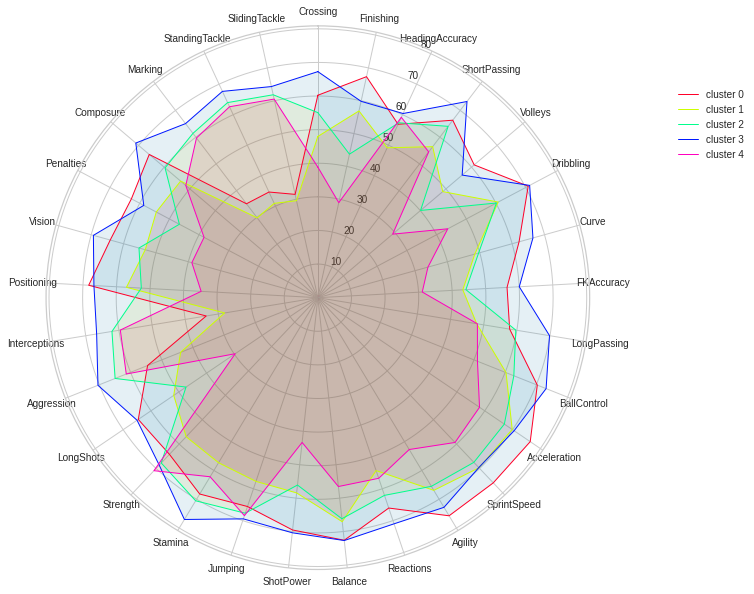

In [55]:
make_cluster_radar(non_gk_new,'Cluster')

**이 radar chart를 통해 어떻게 군집이 된 것인지 추측해볼 수 있다.**

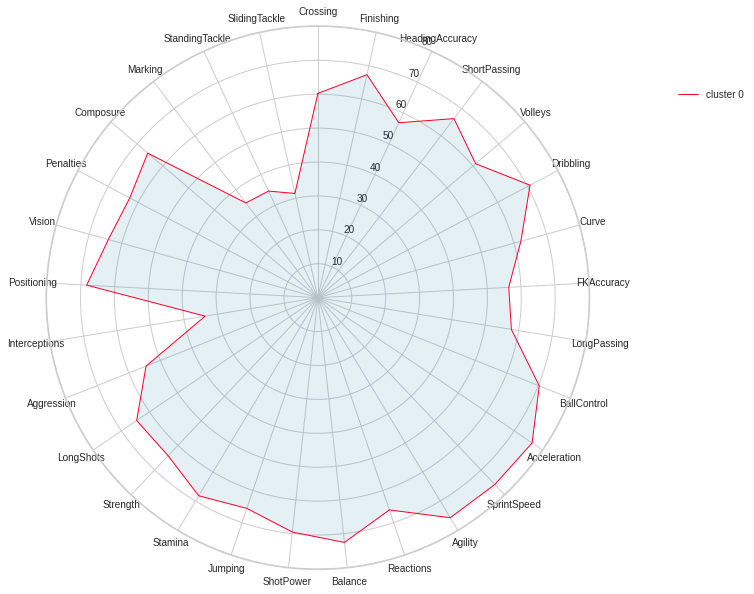

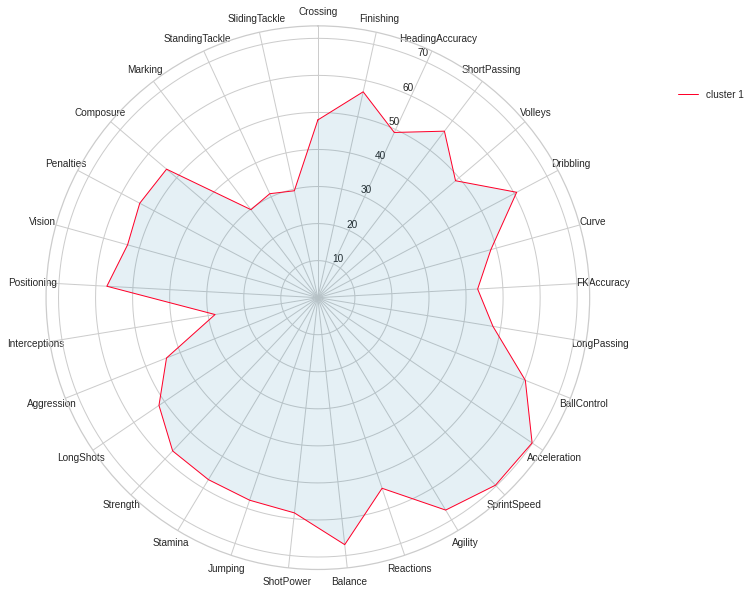

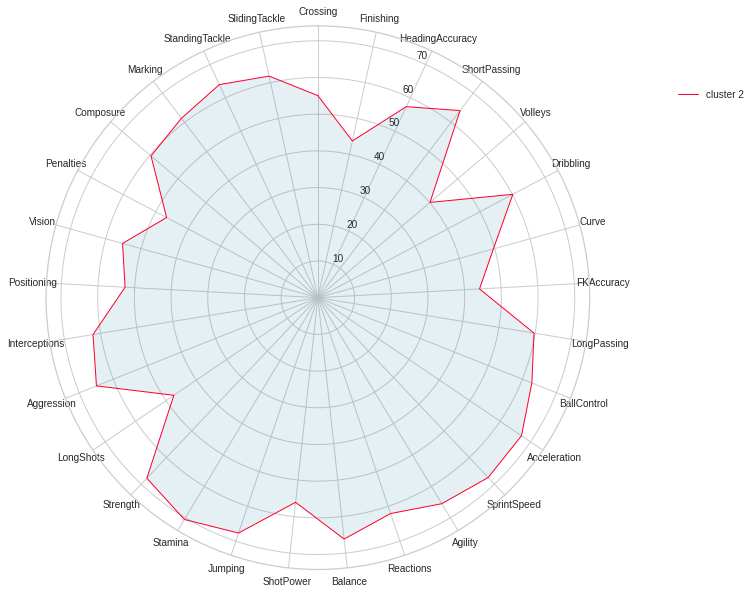

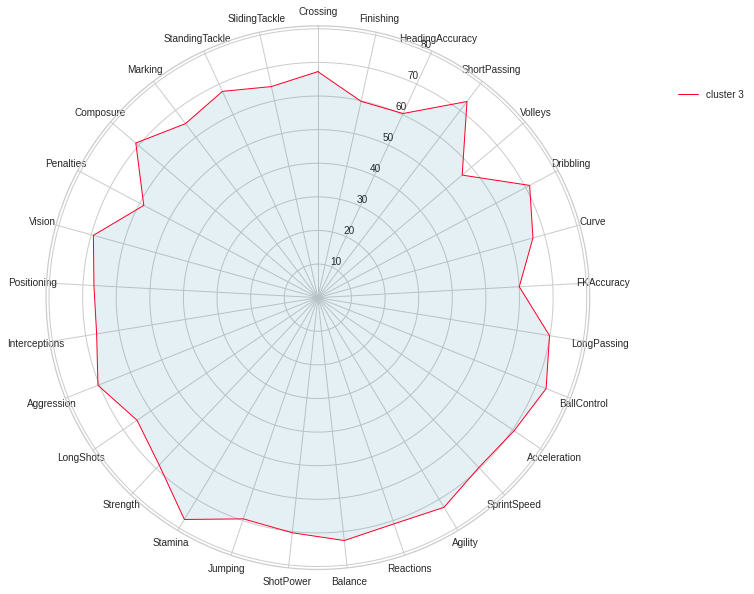

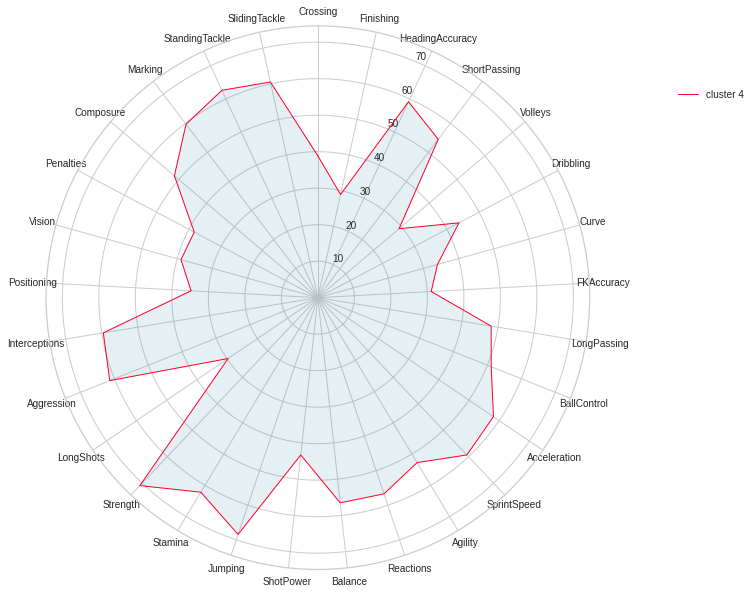

In [56]:
for i in range(5):
  make_cluster_radar(non_gk_new[non_gk_new.Cluster==i], 'Cluster')

## Radar chart for similar player

In [57]:
col1=nongk_pca_kmeans_df.columns[-3:].to_list()
col2=nongk_pca_kmeans_df.columns[:-3].to_list()
new_col=col1+col2
nongk_pca_kmeans_df=nongk_pca_kmeans_df[new_col]
nongk_pca_kmeans_df.head()

,FullName,Cluster,BestPosition,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4
0,Lionel Messi,3,CAM,3.43,2.80,1.20,3.15,3.67,-1.22,0.77,6.726875,0.342237,0.615166,0.181881
1,Karim Benzema,3,CF,2.45,2.67,1.02,2.65,3.09,-1.15,2.02,5.816280,-0.336014,0.132669,1.394052
2,Robert Lewandowski,3,ST,2.24,2.85,0.65,2.45,3.09,-0.85,2.82,5.701664,-1.078143,0.189942,1.999844
3,Kevin De Bruyne,3,CM,3.52,2.80,0.56,2.65,2.86,0.67,1.20,5.878852,-1.407581,0.854530,-0.417365
4,Kylian Mbappé,0,ST,2.14,2.58,2.62,2.95,3.49,-1.07,1.76,6.356858,0.249218,-1.293110,0.964180


In [58]:
# son=nongk_pca_kmeans_df[nongk_pca_kmeans_df['Name']=='H. Son']
# son.values[0,-4:]

In [59]:
def make_player_radar(data,standard_level):  
    attrs=data.columns.drop(standard_level).tolist()
    attrs_data=data[attrs].values
    standard_level=data[standard_level]
    fig, ax = plt.subplots(1, figsize=(10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    angles = np.linspace(0, 2*np.pi, len(attrs), endpoint=False) #radian 기준으로 angle잡음
    angles = np.concatenate((angles,[angles[0]]))
    
    ax.set_thetagrids(angles * 180/np.pi, attrs) # 각도에 따른 grid 및 ticklabels 변경
    #Python NumPy의 삼각함수는 radian을 사용하기 때문에 degree 를 radian으로 바꿔주기 위해서 degree * np.py/180 을 해주었습니다. ( np.deg2rad(x) 함수를 사용해도 됨 )
    ax.grid(True)
    #standard level list에 있는 값들
    #여기까지가 큰틀이고 이제부터 cluster에 적용
    n_players = np.unique(standard_level) # 손흥민만 이씅니까 1
    my_palette = plt.cm.get_cmap("rainbow", len(n_players))
    for i,player in enumerate(n_players):
      color = my_palette(i)
      abilities=attrs_data[i]
      abilities = np.concatenate((abilities, [abilities[0]]))
      ax.plot(angles, abilities,color=color,linewidth=1, linestyle='solid', label='{}'.format(player)) ## 레이더 차트 출력
      ax.fill(angles, abilities, color=color,alpha=0.1) ## 도형 안쪽에 색을 채워준다.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,0.9))

In [60]:
# make_player_radar(name_abil[name_abil.FullName==player_name],'FullName')
# non_gk_new[non_gk_new.Cluster==i]

In [61]:
def SimilarityDistances(df,selected_player,func):
  return_list={}
  similarity_list={}
  selected_player_vec=df[df['FullName']==selected_player].values[0,-4:]
  #선택된 선수의 pca value만 긁어옴
  #values는 array 2차원 형태로 반환됨
  for idx,row in df.iterrows():
    player_name=row['FullName']
    # 같은 클러스터에 이름이 다른 이름이면
    if row['Cluster']==df[df['FullName']==selected_player].values[0,1] and player_name!=selected_player:
      compared_player_vec=[row['PCA Component 1'],row['PCA Component 2'],row['PCA Component 3'],row['PCA Component 4']]
      similarity_list[player_name]=float(sim.cosine_similarity([selected_player_vec],[compared_player_vec])[0])
      # 비슷한 선수마다 simliarity를 기록
  #10개정도 혹은 그보다 적은 수의 표본
  n=10
  similarity_list=OrderedDict(sorted(similarity_list.items(), key=lambda x: x[1], reverse=True))
  idx=0
  for key,value in similarity_list.items():
    if idx<n:
      return_list[key]='{0:0.5f}'.format(value)
      idx+=1
    else:
      break
  return return_list

Input name of the player : Lionel Messi


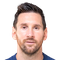

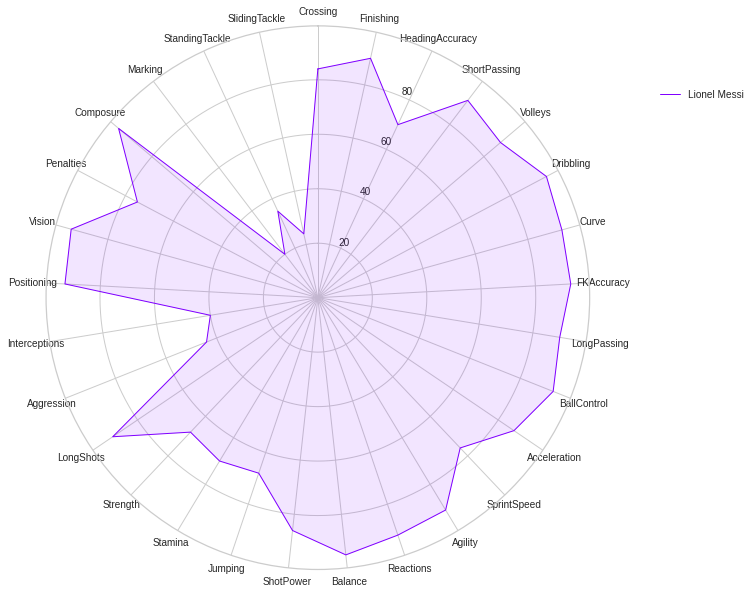

In [62]:
player_name=input("Input name of the player : ")
def player_show(df,player_name):
  player_df=df[df['FullName']==player_name]
  url=player_df.iloc[0,6]
  im = Image.open(requests.get(url, stream=True).raw)
  full_name=df.iloc[:,2]
  nongk_abil=df.iloc[:,39:68]
  name_abil= pd.concat([full_name,nongk_abil.reset_index(drop=True)], axis=1)
  selected_player_radar=make_player_radar(name_abil[name_abil.FullName==player_name],'FullName')
  return im
player_show(non_gk,player_name)


In [63]:
Similar_10players=SimilarityDistances(nongk_pca_kmeans_df,player_name,'cosine')
Similar_10players=pd.DataFrame.from_dict(Similar_10players,orient='index', columns=['Similarity'])
Similar_10players=Similar_10players.rename_axis('FullName').reset_index()

In [ ]:
Similar_10players

In [65]:
# sim=Similar_10players.iloc[0,0]
# pl_df=non_gk[non_gk['FullName']==sim]
# pl_df


In [66]:
# non_gk_fullname = pd.concat([labels_df,nongk_abil.reset_index(drop=True)], axis=1)
# non_gk_fullname

[[84. 90. 70. ... 20. 35. 24.]
 [75. 92. 90. ... 43. 24. 18.]
 [71. 94. 91. ... 35. 42. 19.]
 ...
 [41. 36. 42. ... 39. 37. 48.]
 [21. 20. 41. ... 50. 54. 54.]
 [38. 28. 41. ... 47. 44. 43.]]


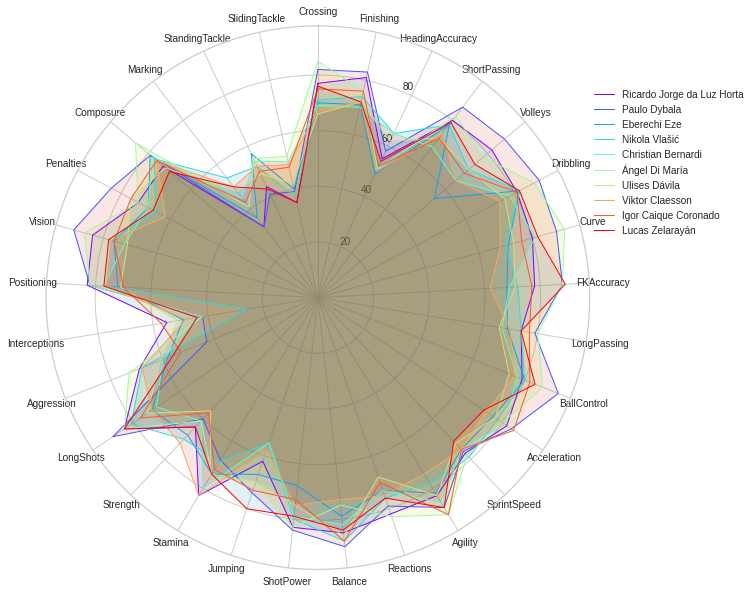

In [67]:
def make_similar_radar(df,sim_data,standard_level):  
    full_name=df.iloc[:,2]
    nongk_abil=df.iloc[:,39:68]
    name_abil= pd.concat([full_name,nongk_abil.reset_index(drop=True)], axis=1)
    attrs=name_abil.columns.drop(standard_level).tolist()
    attrs_data=df[attrs].values
    print(attrs_data)
    # standard_level=df[standard_level] #fullname만 있음
    fig, ax = plt.subplots(1, figsize=(10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1) # 그려지는 방향 시계방향
    angles = np.linspace(0, 2*np.pi, len(attrs), endpoint=False) #radian 기준으로 angle잡음
    angles = np.concatenate((angles,[angles[0]]))
    n_players= len(sim_data)
    color=iter(plt.cm.gist_rainbow(np.linspace(0,1,n_players)))
    ax.set_thetagrids(angles * 180/np.pi, attrs) # 각도에 따른 grid 및 ticklabels 변경
    #Python NumPy의 삼각함수는 radian을 사용하기 때문에 degree 를 radian으로 바꿔주기 위해서 degree * np.py/180 을 해주었습니다. ( np.deg2rad(x) 함수를 사용해도 됨 )
    ax.grid(True)
    #standard level list에 있는 값들
    #여기까지가 큰틀이고 이제부터 cluster에 적용
    my_palette = plt.cm.get_cmap("rainbow", n_players)
    for i in range(n_players):
      c= my_palette(i)
      index=np.where(name_abil['FullName']==sim_data.iloc[i,0])
      abilities=attrs_data[index]
      # abilities=attrs_data[i]
      #  cluster_indexes=np.where(cluster==standard_level) # 클러스터마다 i번째 해당하는 거 싹다 index모아버려
      # abilities=np.mean(attrs_data[cluster_indexes],axis=0)
      # abilities = np.concatenate((abilities, [abilities[0]]))
      abilities = np.concatenate([abilities[0], [abilities[0][0]]])
      ax.plot(angles, abilities,color=c,linewidth=1, linestyle='solid', label='{}'.format(sim_data.iloc[i,0])) ## 레이더 차트 출력
      ax.fill(angles, abilities,c,alpha=0.1) ## 도형 안쪽에 색을 채워준다.
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,0.9))
make_similar_radar(non_gk,Similar_10players,'FullName')

similar 한 선수들 index를 활용하여 원래 선수와 similar한 선수 radar차트 그려보자 radar function은 그대로

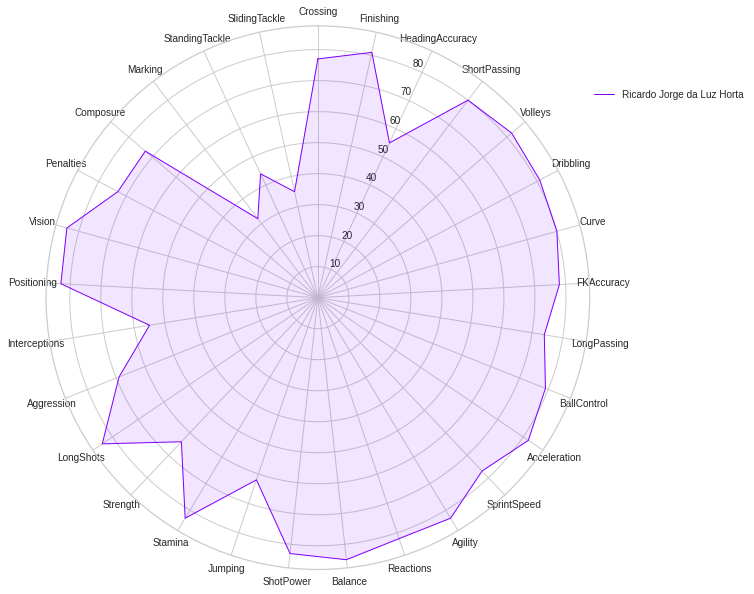

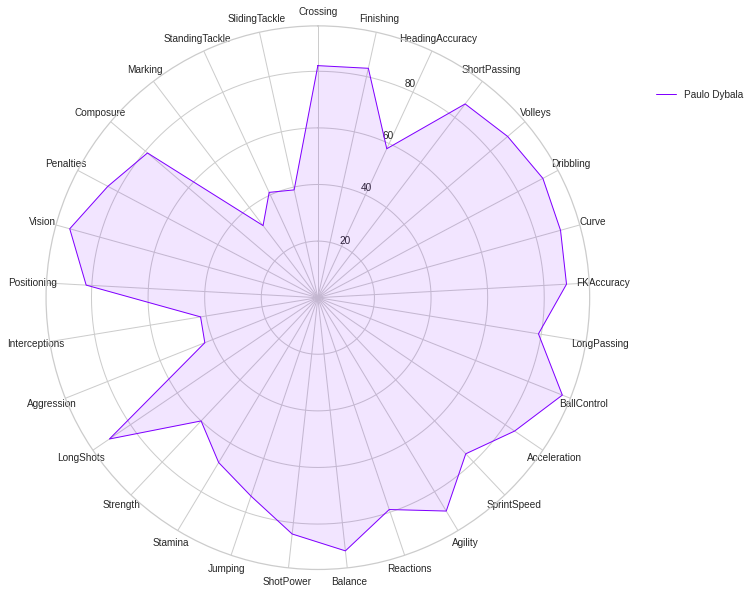

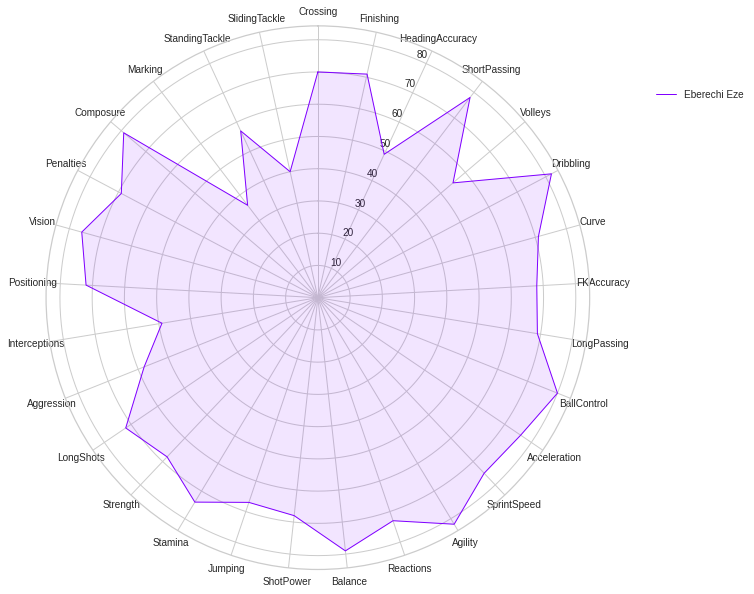

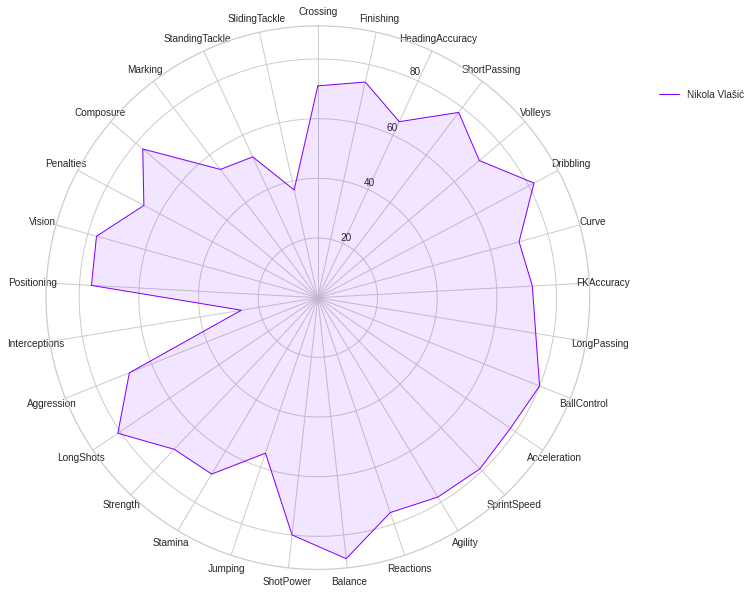

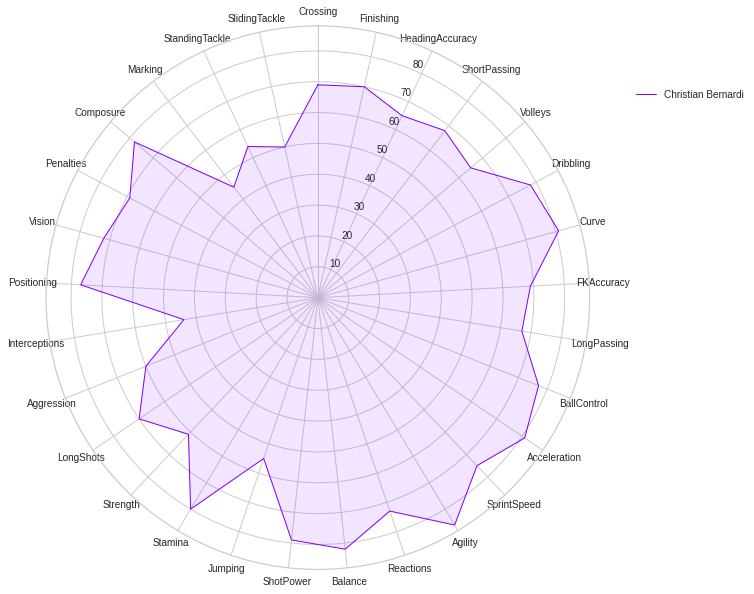

In [68]:
def simplayer_show(df,Sim_players):
  simplayer_name=Sim_players.iloc[i,0]
  player_df=df[df['FullName']==simplayer_name]
  url=player_df.iloc[0,6]
  im = Image.open(requests.get(url, stream=True).raw)
  full_name=df.iloc[:,2]
  nongk_abil=df.iloc[:,39:68]
  name_abil= pd.concat([full_name,nongk_abil.reset_index(drop=True)], axis=1)
  im.show()
  selected_player_radar=make_player_radar(name_abil[name_abil.FullName==simplayer_name],'FullName')
  return im
#5개만 보여주자..

for i in range(5):
  simplayer_show(non_gk,Similar_10players)

## crawling data and find alternate players






In [69]:
# !pip install git+https://github.com/devinpleuler/analytics-handbook.git
# from soccerutils.statsbomb import get_events
# from soccerutils.pitch import Pitch

**Let's start crawling!** 

Expected goals (xG) is the new revolutionary football metric, which allows you to evaluate team and player performance.

In [70]:
url='https://understat.com/league/EPL/2022'
res=requests.get(url)
soup=BeautifulSoup(res.content,"lxml")
# Based on the structure of the webpage, I found that data is in the JSON variable, under 'script' tags
scripts = soup.find_all('script')

To get the json data from the Understat page we must first request, find it and execute the script we want , in this case number [1] , the groupData.

We found that the data interesting us is stored in teamsData variable, after creating a soup of html tags it becomes just a string, so we find that text and extract JSON from it.

we understand that this is a dictionary of dictionaries of 3 keys: id, title and history. The first layer of dictionary uses ids as keys too.

In [71]:
json_data=''
for elem in scripts:
  if 'teamsData' in str(elem):
    json_data=str(elem).strip()
index_start= json_data.index("('")+2
index_end= json_data.index("')")
json_data = json_data[index_start:index_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data=json.loads(json_data)

columns 추출

In [72]:
columns=[]
for id in data.keys():
  columns=list(data[id]['history'][0].keys())
columns

['h_a',
 'xG',
 'xGA',
 'npxG',
 'npxGA',
 'ppda',
 'ppda_allowed',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'result',
 'date',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD']

In [73]:
# Get teams and their relevant ids and put them into separate 
epl_teams={}
for id in data.keys():
  epl_teams[id]=data[id]['title']
epl_teams

{'71': 'Aston Villa',
 '72': 'Everton',
 '73': 'Bournemouth',
 '74': 'Southampton',
 '75': 'Leicester',
 '78': 'Crystal Palace',
 '80': 'Chelsea',
 '81': 'West Ham',
 '82': 'Tottenham',
 '83': 'Arsenal',
 '86': 'Newcastle United',
 '87': 'Liverpool',
 '88': 'Manchester City',
 '89': 'Manchester United',
 '220': 'Brighton',
 '228': 'Fulham',
 '229': 'Wolverhampton Wanderers',
 '244': 'Brentford',
 '245': 'Leeds',
 '249': 'Nottingham Forest'}

In [74]:
data[id]['history']

[{'h_a': 'a',
  'xG': 0.235825,
  'xGA': 1.8591,
  'npxG': 0.235825,
  'npxGA': 1.8591,
  'ppda': {'att': 200, 'def': 15},
  'ppda_allowed': {'att': 152, 'def': 25},
  'deep': 2,
  'deep_allowed': 24,
  'scored': 0,
  'missed': 2,
  'xpts': 0.2541,
  'result': 'l',
  'date': '2022-08-06 14:00:00',
  'wins': 0,
  'draws': 0,
  'loses': 1,
  'pts': 0,
  'npxGD': -1.623275},
 {'h_a': 'h',
  'xG': 1.9717,
  'xGA': 2.08634,
  'npxG': 1.9717,
  'npxGA': 1.32517,
  'ppda': {'att': 173, 'def': 16},
  'ppda_allowed': {'att': 123, 'def': 15},
  'deep': 4,
  'deep_allowed': 7,
  'scored': 1,
  'missed': 0,
  'xpts': 1.2978,
  'result': 'w',
  'date': '2022-08-14 13:00:00',
  'wins': 1,
  'draws': 0,
  'loses': 0,
  'pts': 3,
  'npxGD': 0.64653},
 {'h_a': 'a',
  'xG': 0.918315,
  'xGA': 1.43408,
  'npxG': 0.918315,
  'npxGA': 1.43408,
  'ppda': {'att': 221, 'def': 14},
  'ppda_allowed': {'att': 242, 'def': 13},
  'deep': 1,
  'deep_allowed': 8,
  'scored': 1,
  'missed': 1,
  'xpts': 0.9539,
  're

After this code finishes running we have a dictionary of DataFrames where key is the name of the team and value is the DataFrame with all games of that team.

In [75]:
tables={}
for id,team in epl_teams.items():
  team_data=[]
  #경기들의 데이터 모두 append
  for row in data[id]['history']:
    team_data.append(list(row.values()))
  df=pd.DataFrame(team_data,columns=columns)
  tables[team]=df #team이 key, df가 value
tables

{'Aston Villa':    h_a        xG       xGA      npxG     npxGA                     ppda  \
 0    a  0.488895  0.588341  0.488895  0.588341  {'att': 152, 'def': 23}   
 1    h  2.666960  1.375070  2.666960  1.375070  {'att': 214, 'def': 23}   
 2    a  0.803828  2.911370  0.803828  2.006620  {'att': 252, 'def': 34}   
 3    h  0.304555  0.334589  0.304555  0.334589  {'att': 243, 'def': 18}   
 4    a  0.297168  2.799710  0.297168  2.799710  {'att': 278, 'def': 19}   
 5    h  0.279392  1.921430  0.279392  1.921430  {'att': 483, 'def': 11}   
 6    h  1.343650  0.218302  1.343650  0.218302  {'att': 232, 'def': 39}   
 7    a  1.896450  0.298626  1.896450  0.298626  {'att': 230, 'def': 24}   
 8    a  0.657187  0.221346  0.657187  0.221346  {'att': 157, 'def': 22}   
 9    h  2.445420  1.236430  2.445420  1.236430  {'att': 379, 'def': 27}   
 10   a  0.711487  2.892000  0.711487  2.130830  {'att': 279, 'def': 15}   
 
                ppda_allowed  deep  deep_allowed  scored  missed    xpt

In [76]:
tables['Nottingham Forest'].sample()

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
5,h,1.32895,0.905041,0.567779,0.905041,"{'att': 232, 'def': 17}","{'att': 251, 'def': 16}",6,10,2,3,1.7698,l,2022-09-03 14:00:00,0,0,1,0,-0.337262


ppda와 ppda_allowed가 dict형태로 나타남

`{'att': 464, 'def': 10}	{'att': 147, 'def': 23}`

In [77]:
for team,df in tables.items():
  tables[team]['ppda']=tables[team]['ppda'].apply(lambda x:x['att']/x['def'] if x['def']!=0 else 0)
  tables[team]['ppda_allowed']=tables[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)

합계를 통해 데이터를 구해야 하는 데이터와 평균으로 구해야 하는 데이터가 있음

In [78]:
columns_tosum=['h_a',
 'xG',
 'xGA',
 'npxG',
 'npxGA',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'result',
 'date',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD']
 
columns_tomean=['ppda',
 'ppda_allowed']

We are ready to calculate our totals and means. For this we loop through dictionary of dataframes and call .sum() and .mean() DataFrame methods that return Series, that’s why we add .transpose() to those calls. We put these new DataFrames into a list and after that concat them into a new DataFrame full_stat.

In [83]:
final_df=[]
for team, df in tables.items():
  sum_data = pd.DataFrame(df[columns_tosum].sum()).transpose()
  mean_data = pd.DataFrame(df[columns_tomean].mean()).transpose()
  team_df = pd.concat([sum_data,mean_data],axis=1)
  team_df['team'] = team
  team_df['matches'] = len(df)
  final_df.append(team_df) # 하나에 몽땅
final_df=pd.concat(final_df)

final_df['xG_diff']=final_df['xG']-final_df['scored']
final_df['xGA_diff']=final_df['xGA']-final_df['missed']
final_df['xpts_diff']=final_df['xpts']-final_df['pts']
final_df.sort_values('pts', ascending=False, inplace=True)
final_df['position'] = range(1,len(final_df)+1)
col_order = ['position', 'team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda',
 'ppda_allowed', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
final_df=final_df[col_order]
final_df=final_df.set_index('position')
final_df.loc[(final_df['xG_diff']>0) & (final_df['xGA_diff']<0)&(final_df['xpts_diff']>0),:]

,team,matches,wins,draws,loses,scored,missed,pts,xG,xG_diff,...,xGA,xGA_diff,npxGA,npxGD,ppda,ppda_allowed,deep,deep_allowed,xpts,xpts_diff
position,,,,,,,,,,,,,,,,,,,,,
8,Brighton,11,4,3,4,15,14,15,19.311405,4.311405,...,12.54567,-1.45433,11.02334,6.004551,11.170905,16.562964,98,73,20.1751,5.1751
14,Southampton,11,3,2,6,10,18,11,11.087585,1.087585,...,16.40229,-1.59771,16.40229,-5.314705,13.858200,8.634616,63,90,11.6228,0.6228
16,Leeds,10,2,3,5,11,15,9,13.667296,2.667296,...,13.758388,-1.241612,12.997228,-0.091102,7.795775,9.907440,67,60,13.8295,4.8295
17,Aston Villa,11,2,3,6,7,16,9,11.894992,4.894992,...,14.797214,-1.202786,13.131294,-1.236302,13.697357,14.242154,71,69,14.4017,5.4017
19,Nottingham Forest,12,2,3,7,8,23,9,12.7886,4.7886,...,21.346448,-1.653552,19.06294,-7.796678,18.918266,10.256830,41,119,11.3579,2.3579


xG,xGA 값으로 알아보는 클럽의 지표들

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


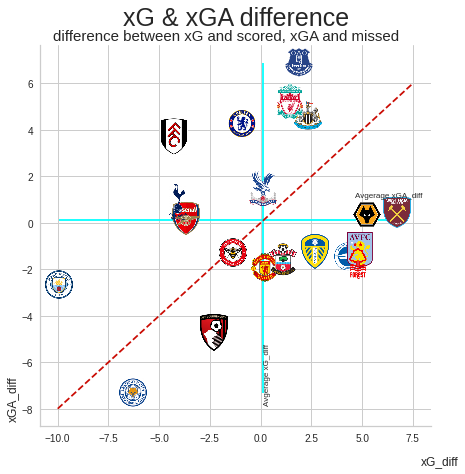

In [160]:
xg_selected= ['team','xG', 'xG_diff','xGA', 'xGA_diff','xpts', 'xpts_diff']
xg_df=final_df[xg_selected]
xg_df['path']=xg_df['team']+'.png'
fig,ax=plt.subplots(figsize=(7,7))
plt.plot([-10,7.5],[-8,6],'r--')
# # Change plot spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(xg_df['xG_diff'],xg_df['xGA_diff'],color='w')

for index, row in xg_df.iterrows():
    logo=OffsetImage(plt.imread('/content/drive/MyDrive/GB1/' +row['path']), zoom=.20, alpha = 1)
    ab = AnnotationBbox(logo, (row['xG_diff'], row['xGA_diff']),frameon=False)
    ax.add_artist(ab)
# Add average lines
plt.hlines(xg_df['xGA_diff'].mean(), xg_df['xG_diff'].min(),xg_df['xG_diff'].max(), color='aqua')
plt.vlines(xg_df['xG_diff'].mean(),xg_df['xGA_diff'].min(),xg_df['xGA_diff'].max(), color='aqua')

fig.text(.29,.92,'xG & xGA difference',size=25)
fig.text(.15,.89,'difference between xG and scored, xGA and missed',size=15)

fig.text(.06,.14,'xGA_diff',size=12,rotation=90)
fig.text(.88,0.05,'xG_diff',size=12)

fig.text(.75,.58,'Avgerage xGA_diff',size=8)
fig.text(.57,.17,'Avgerage xG_diff', size=8,rotation=90)
plt.show()

공격, 수비, 미들을 통해 어느쪽이 문제인지 살펴보자

Next we reorder columns for better readability, sort rows based on points, reset index and add column ‘position’.

player data

In [150]:
# Entering the league's  link
link = "https://understat.com/league/EPL"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the players stats 
strings = scripts[3].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
# Creating the dataframe
df = pd.DataFrame(data)
df.loc[(df['team_title']=='Nottingham Forest'),:]

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
26,7814,Taiwo Awoniyi,11,432,3,3.820949003100395,0,0.6826572511345148,14,5,0,0,F S,Nottingham Forest,3,3.820949003100395,2.6204756889492273,0.17131400667130947
64,10760,Brennan Johnson,12,981,2,3.0050620697438717,0,1.0019658021628857,15,6,2,0,F M S,Nottingham Forest,1,1.4827243946492672,2.999979827553034,0.5152896270155907
72,532,Cheikhou Kouyaté,9,497,1,0.17214820720255375,0,0.8150621205568314,5,5,2,0,D M S,Nottingham Forest,1,0.17214820720255375,1.2654419597238302,1.0655491948127747
128,9301,Emmanuel Dennis,7,224,1,0.3875197321176529,0,0.3418114669620991,7,2,2,0,F S,Nottingham Forest,1,0.3875197321176529,0.7371138818562031,0.5211160965263844
137,10759,Lewis O&#039;Brien,8,490,1,0.40203177370131016,0,0.17910510301589966,6,4,2,0,M S,Nottingham Forest,1,0.40203177370131016,1.470571756362915,0.9467007964849472
144,458,Steve Cook,10,778,0,0.05456392467021942,0,0.7961931601166725,1,3,4,0,D S,Nottingham Forest,0,0.05456392467021942,0.5786601938307285,0.5786601938307285
160,558,Jesse Lingard,10,674,0,0.4778410866856575,0,0.3197498843073845,7,9,1,0,F M S,Nottingham Forest,0,0.4778410866856575,1.8168850373476744,1.2636584714055061
187,767,Jack Colback,3,119,0,0,0,0.25832003355026245,0,1,0,0,M S,Nottingham Forest,0,0,0.36777958273887634,0.10945954918861389
211,1488,Remo Freuler,8,573,0,0.07246982119977474,0,0.11357666924595833,2,2,2,0,M S,Nottingham Forest,0,0.07246982119977474,1.2148219607770443,1.157809166237712
245,3600,Serge Aurier,4,263,0,0,0,0.06393925473093987,0,2,1,0,D S,Nottingham Forest,0,0,0.5052649304270744,0.45985930413007736


### recommend squad for man utd?